# Face Recognition Pipeline Main Execution Jupyter Notebook

This jupyter notebook combines the basic template code provided by Tensorflow's Object Detection API with Siamese Network based deep learning face recognition model provided in Coursera's Deeplearning.ai's face recognition code. The goal is to create a fully functional face recognition system that combines a face detection program utilizing Tensorflow's Object Detection API with pre-trained face recognition deep CNN model.

## The face recognition pipeline is divided into two main components
### 1) Face detection using object detection algorithm
### 2) Siamese Network based deep learning network for extracting encoded vector for face recognition

In the implementation, the face detection portion will be prepared followed by the face recognition portion

# Imports

In [1]:
#First portion of the imports are from Tensorflow Object Detection API
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
from tensorflow.python.client import device_lib
import zipfile

from collections import defaultdict
from io import StringIO
import matplotlib.pylab as plt

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

#This second portion of the imported packages are from Coursera
#Deeplearning.ai's face recognition module
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
from numpy import genfromtxt
import pandas as pd
from fr_utils import *
from inception_blocks_v2 import *
import matplotlib.pylab as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
import PIL
from PIL import Image

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=np.nan)

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#This code is run to ensure correct hardwares are powering the Tensorflow's code
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5588806518946356224, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4973278003
 locality {
   bus_id: 1
 }
 incarnation: 15073162868041669194
 physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"]

## Env setup

In [3]:
# This is needed to display the images.
%matplotlib inline

## 1) Object detection code
Here are the imports from the object detection module.

In [4]:
from utils import label_map_util

from utils import visualization_utils as vis_util

D:\face_recognition_full_version\models\object_detection\utils\visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "D:\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "D:\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "D:\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 478, in start
    self.io_loop.start()
  File "D:\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py

### Model preparation 

### Variables

For this specific project, a face detection model was built using images of soccer players crawled from Google. To ensure accuracy, after testing several models, the Inception based RCNN model was shown to perform the best.

In [5]:
# What model to download.
MODEL_NAME = 'face_recognition_inception_200k_20180604'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'messi_son_face_20180524_map.pbtxt')

NUM_CLASSES = 1

### Load a (frozen/trained) Tensorflow model into memory.

In [6]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

### Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [7]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
#Add the database fact as the secondary category
categories.append({'id' : 2, 'name' : 'Charlie'})
print(categories)
category_index = label_map_util.create_category_index(categories)

[{'id': 1, 'name': 'face'}, {'id': 2, 'name': 'Charlie'}]


### Helper code

In [8]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

### Load images for detection

In [9]:
# Specify the folder that contains all the images
PATH_TO_TEST_IMAGES_DIR = 'face_test'
image_list = os.listdir(PATH_TO_TEST_IMAGES_DIR)
TEST_IMAGE_PATHS = []
for item in image_list:
    TEST_IMAGE_PATHS.append(os.path.join(PATH_TO_TEST_IMAGES_DIR, item))

print(TEST_IMAGE_PATHS)
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

['face_test\\celebrity_1.jpg', 'face_test\\celebrity_2.jpg', 'face_test\\messi_10062.jpg', 'face_test\\son_10010.jpg', 'face_test\\son_71.jpg', 'face_test\\son_72.jpg', 'face_test\\WIN_20180910_00_23_36_Pro.jpg', 'face_test\\WIN_20180910_00_23_55_Pro.jpg', 'face_test\\WIN_20180910_01_01_36_Pro.jpg', 'face_test\\WIN_20180910_01_02_40_Pro.jpg']


## 2) Face Recognition Code

This portion of the code was derived from the face recognition exercise in Coursera's deeplearning.ai specialization. I've modified the code so as to not show the solutions to some of the exercise problems as that can violate Coursera's honor code.

### Load pre-trained face recognition neural network

The pretrained model takes an input image of 96 x 96 x 3. It appears that the weightse were somehow extracted from OpenFace's nn2.simplev2 model.

In [10]:
#faceRecoModel function implements deep NN face recognition model. One can notice that
#the output of the model is not a softmax layer, but rather a vector of 128 dimension
#which is the encoding of the image that will later be used for distance metric of face
#images. 
FRModel = faceRecoModel(input_shape = (3, 96, 96))

In [11]:
#This is to ensure that all weights (3743280) are correctly loaded
print('Total Params: ', FRModel.count_params())

Total Params:  3743280


In [12]:
load_weights_from_FaceNet(FRModel)

### Creating 128 vector database for face image

The approach is to compare the normalized distance between the vector output from the faceRecoModel. In order to recognize a face, we must have basis information from which we can compare the new incoming data.

In this particular project, my face will be the only face data that will be stored. But for more practical applications (say a face recognition security system for a company's entrance), one would of course have significantly larger database.

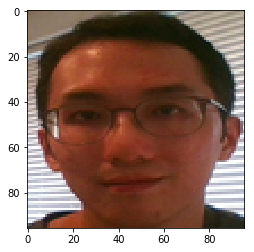

In [13]:
#These are two face images that will be used
database_1 = Image.open("face_images/database1.jpg")
imshow(database_1)

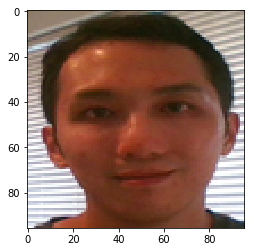

In [14]:
database_2 = Image.open("face_images/database2.jpg")
imshow(database_2)

In [15]:
face_data = []
label = "face_images/database1.jpg"
face_data.append(img_to_encoding(label, FRModel))
label2 = "face_images/database2.jpg"
face_data.append(img_to_encoding(label2, FRModel))

In [16]:
#Create the database that will be used in the subsequent function
database = {}
database['Charlie'] = face_data

### Helper function that compares incoming face image with images stored in the database

In [17]:
def face_recognize(image, database, model):
    '''This function takes an input image of a face, encodes it using the OpenFace
    neural network and compares the encoded information to the pre-encoded information
    in the database to check whether the face belongs to a registered personel'''
    
    #Encode the input face image
    encoding = img_to_encoding_direct(image, model)
    
    #Set the initial distance to some large number
    min_dist = 100
    
    #Looping over the entire database
    for name, db_enc in database.items():
        #Since the database now contains multiple encoding per person, we need another loop
        #to loop through the various encodings associated with each person
        for data_num in range(len(db_enc)):
            #First compute the L2 distance between input image encoding and the current loop encoding
            dist = np.linalg.norm(encoding - db_enc[data_num][0])

            #If the distance is smaller than the preset min_dist, set the current distance as the min_dist
            if dist < min_dist:
                min_dist = dist
                identity = name
        
    #This means none of the faces match the images in the database
    #0.68 is an empirically determined value that performs well for the purpose
    #of this project.
    if min_dist > 0.68:
        identity = "unknown"
    
    return identity, min_dist

## 3) Pipelining the face detection model with deep learning NN face model

The basic idea is

1) Detect Face

2) Crop and resize the face portion of the image

3) Feed it to the pre-trained NN model

4) Check whether it matches any of the faces registered in the database
(In this case, my face is the only one on the database)

5) If there is a match, manipulate the output_dict from Tensorflow API model for correct label

In [18]:
#This is a custom helper function that helps extract detected face images
#from face detection. The extracted images will be fed into face recognition
#model for analysis.
def detect_face(image, score_list, box_list, threshold = 0.9):
    '''
        image: numpy representation of the image that is being analyzed
        score_list: a list containing the confidence values of the objects being detected
        box_list: a list containing the coordinate information of the detected objects
                  Keep in mind that the coordinates are normalized
        threshold: since we are dealing with face recognition, I set it up at a high value
    '''
    #Threshold list is used to keep track of scores above threshold
    threshold_list = []
    for score in score_list:
        if score > threshold:
            threshold_list.append(score)
            
    #We want to grab the box coordinates for the objects that had confidence score
    #above the threshold. For multi class object detection, we probably want to keep
    #track of what each object is, but, in the current implementation, we only care 
    #about face detection.
    box_info = box_list[:len(threshold_list)]
    #Converting the list to numpy array so I can perform multiplication
    box_info_np = np.array(box_info)
    
    #Create a list containing the width and height of the image so we can convert
    #the box coordinates to absolute scale from normalized scale. We need to append
    #y and x sizes twice so we can get desirable results when we perform matrix
    #multiplication.
    image_size = []
    image_size.append(image.shape[0])
    image_size.append(image.shape[1])
    image_size.append(image.shape[0])
    image_size.append(image.shape[1])
    image_size_np = np.array(image_size)
    
    #Derive absolute coordinate using the normalized coordinate and image size
    abs_coord = np.multiply(box_info_np, image_size_np)
    
    #Since we can have multiple images loop through multiple images
    image_list = []
    for i in range(abs_coord.shape[0]):
        y_min = int(abs_coord[i][0])
        x_min = int(abs_coord[i][1])
        y_max = int(abs_coord[i][2])
        x_max = int(abs_coord[i][3])
        image_list.append(image[y_min:y_max, x_min:x_max])
        
    return image_list

In [19]:
#Helper function provided in the Tensorflow Object Detection API
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in ['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes', 'detection_masks']:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [20]:
#Another custum helper function othat takes a PIL object image, resize it
#such that it is size 96 x 96. The returned image is of data type numpy array
def resize_image(img, dimension=(96, 96)):
    """
    the input img is a numpy array. We must first convert it to PIL object
    before resizing it.
    """
    img_resize = img.resize(dimension, Image.ANTIALIAS)
    img_resize_np = np.array(img_resize)
    return img_resize_np

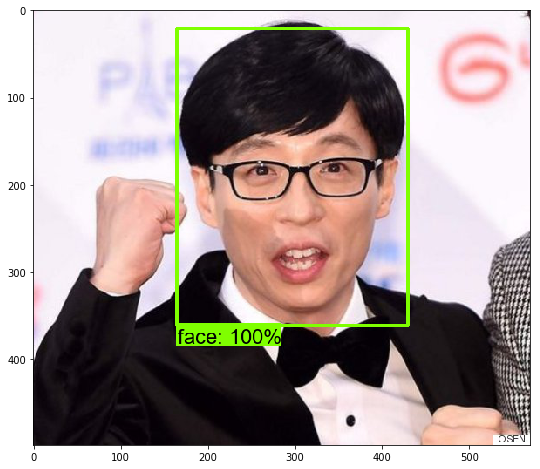

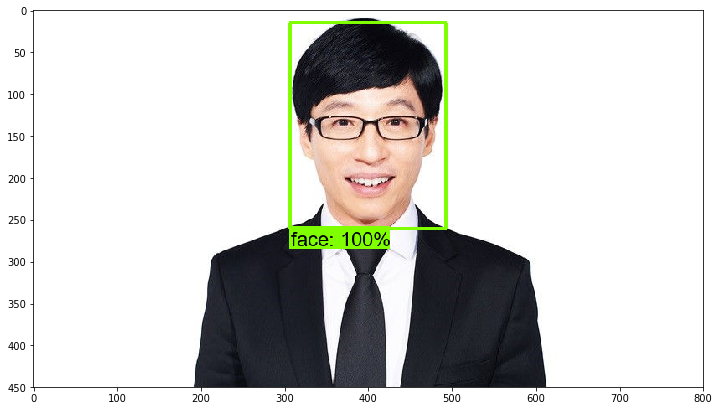

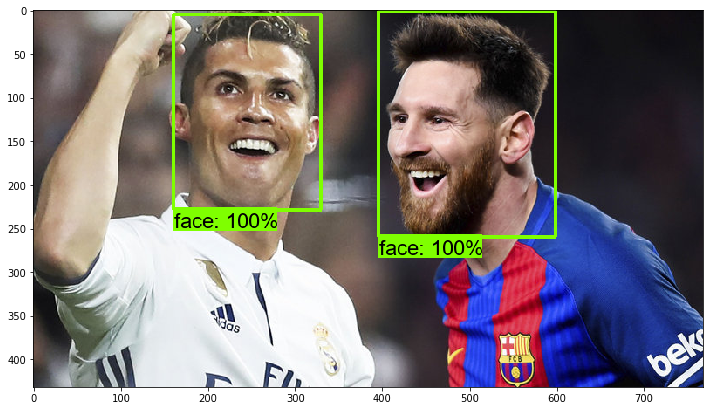

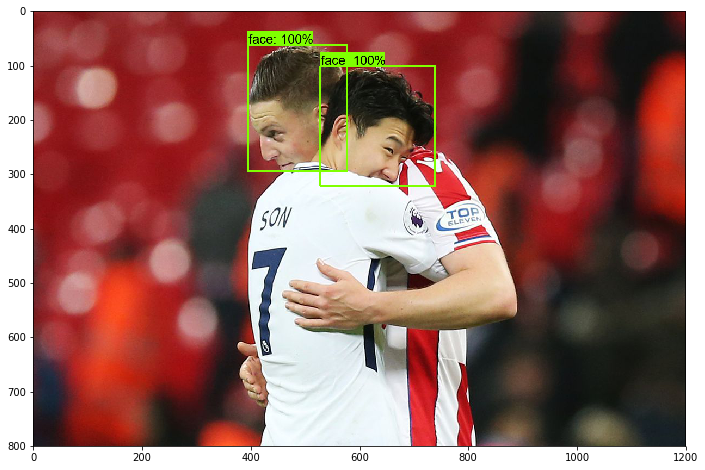

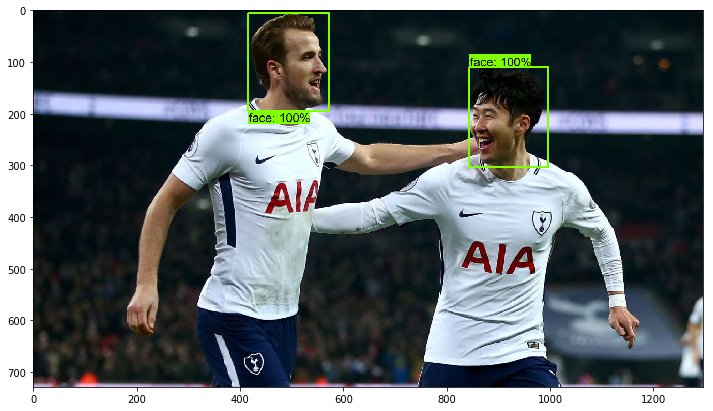

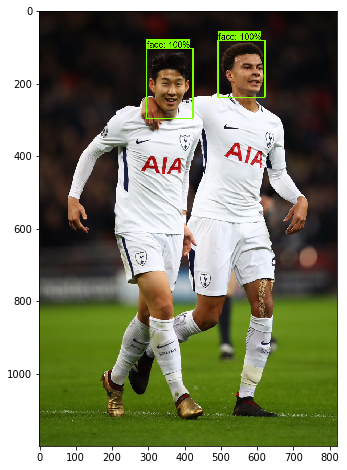

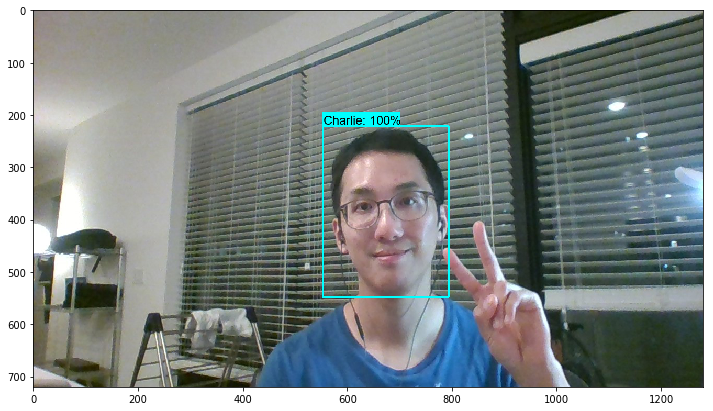

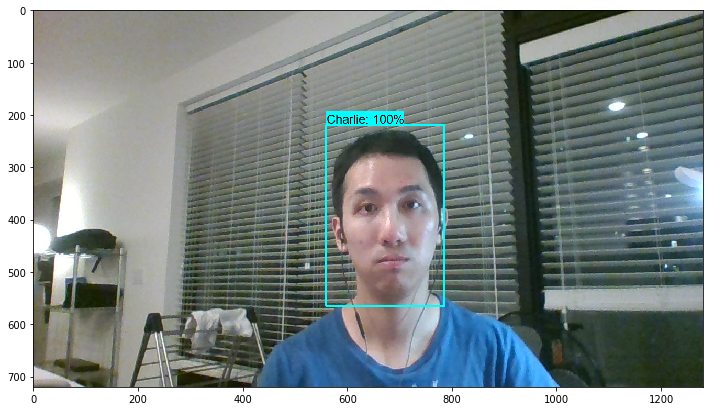

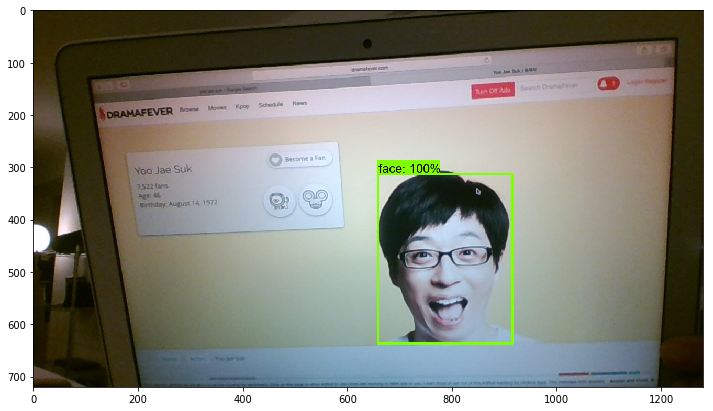

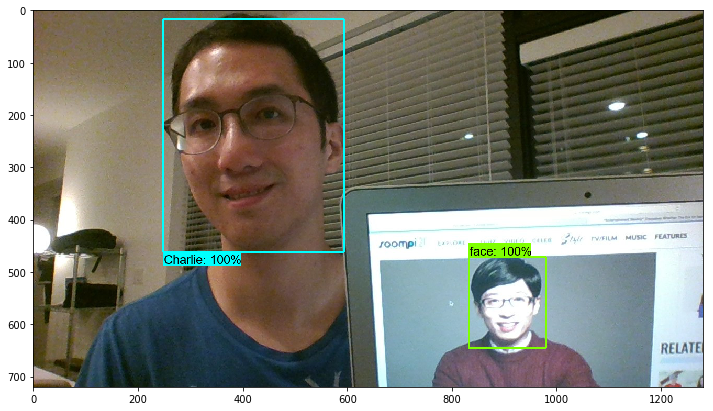

In [21]:
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    #In order to assign the numpy array to a separate object with a different pointer, we need to use np.copy
    image_np_original = np.copy(image_np)
    
    #Show the original image for analysis purposes (Comment out if you don't need it)
    #plt.figure(figsize=IMAGE_SIZE)
    #plt.imshow(image_np_original)
    
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    
    # Now that we have output_dict, we can run the detect_face function to extract face images
    image_list = detect_face(image_np_original, output_dict['detection_scores'], output_dict['detection_boxes'])
    
    # Display the cropped images for analysis (Can comment it out)
    image_counter = 0
    for image in image_list:
        img = PIL.Image.fromarray(image)
        resized_img = resize_image(img)
        #face_recognize uses a modified version of img_to_encoding
        #and requires a numpy array version of image inserted directly
        identity, min_dist = face_recognize(resized_img, database, FRModel)
        #As soon as face_recognize model recognizes my face, I convert
        #the class index to 2 which corresponds to my face
        if identity == "Charlie":
            output_dict['detection_classes'][image_counter] = 2
        image_counter += 1
    
    # Visualization of the results of a detection. The method uses
    #output_dict['detection_classes'] and category_index to extract
    #the label. For this particular model, we've already converted
    #the labels when it finds my face. So that should be automatically
    #reflected.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True, line_thickness=4)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

## 4) Conclusion

As it can be seen, the model does extremely well to detect any faces present in the image. Furthermore, at least from the test images that were used, the model does an excellent job finding my face.

Also, one might wonder what if we just train the object detection model with different face data. I've tried this, and this generally doesn't perform very well. In some of the attempts I've made with higher accuracy object detection models, the model sometimes became race classification (as in many Caucassian faces were recognized by one of the Caucassian individual in the dataset etc), or sometimes it just became a confused face detection model that occassionally detects the right face.

### Modifications and suggestions

1) There are many open sourced face recognition NN models available. Some are based on Facebook's face recognition model which have been shown to have ~99% accuracy and is used in Facebook's photo face recognition from what I've read. Last time I checked, the models were ported to Linux and MacOS but not to Windows. But as these open sourced projects become more refined, one can probably build even more robust face recognition system.

2) This module can be slightly modified to be used with real time video streaming. OpenCV has built in methods that read and output each frame of a live stream from a webcam or security camera. To get smoother FPS, one will obviously need strong hardware to run the model.

## 5) References

#### a) For object detection, follow instructions from these Youtube videos

Sentdex Object Detection Tutorial: https://www.youtube.com/watch?v=COlbP62-B-U&t=1s 

Edje Electronics Object Detection Tutorial: https://www.youtube.com/watch?v=Rgpfk6eYxJA 

Their respective personal blogs are:

Sentdex: https://pythonprogramming.net/introduction-use-tensorflow-object-detection-api-tutorial/ 

Edje Electronics: https://github.com/EdjeElectronics/TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10/blob/master/generate_tfrecord.py 

#### b) For face recognition related material,

Coursera Deeplearning.ai: https://www.coursera.org/specializations/deep-learning

Specifically refer to Week 4 of Convolutional Neural Network portion for more details

Some other good blogs and Github references

https://github.com/davidsandberg/facenet

https://medium.com/@vinayakvarrier/building-a-real-time-face-recognition-system-using-pre-trained-facenet-model-f1a277a06947

https://github.com/ageitgey/face_recognition#face-recognition

https://cmusatyalab.github.io/openface/